Import libs

In [2]:
import pandas as pd
import numpy as np
import functools as ft
import matplotlib.pyplot as plt
import scipy.stats as stats
import operator

Load the data

In [3]:
#date_parser = lambda date: 0 if date is None else np.datetime64(
#    pd.to_datetime(date,format ="%d%b%Y"),dtype="datetime64[s]")

date_parser = ft.partial(pd.to_datetime,format ="%d%b%Y")

MUNICIPLAITY_CODE_2_STR = {
    "0114": "Upplands Väsby",
    "0115": "Vallentuna",
    "0117": "Österåker",
    "0120": "Värmdö",
    "0123": "Järfälla",
    "0125": "Ekerö",
    "0126": "Huddinge",
    "0127": "Botkyrka",
    "0128": "Salem",
    "0136": "Haninge",
    "0138": "Tyresö",
    "0139": "Upplands-Bro",
    "0140": "Nykvarn",
    "0160": "Täby",
    "0162": "Danderyd",
    "0163": "Sollentuna",
    "0180": "Stockholm",
    "0181": "Södertälje",
    "0182": "Nacka",
    "0183": "Sundbyberg",
    "0184": "Solna",
    "0186": "Lidingö",
    "0187": "Vaxholm",
    "0188": "Norrtälje",
    "0191": "Sigtuna",
    "0192": "Nynäshamn"
}

DATASET_BASE = "../dataset/"

PERSON = pd.read_csv(DATASET_BASE + "person.csv", index_col="lopnr_new",
                     parse_dates=["birth_date","deathdate"],date_parser=date_parser
                    ).rename(columns={"deathdate":"death_date"})
PERSON.name = "Person"

DIAGNOSES = pd.read_csv(DATASET_BASE + "diagnoses.csv", index_col="lopnr_new",
                       parse_dates=["diagdate","rad_date","kem_date","surg_date"],
                        date_parser=date_parser,dtype={"lkf_dx":np.str}
                       ).replace({"lkf_dx":MUNICIPLAITY_CODE_2_STR})
DIAGNOSES.name = "Diagnoses"

PSA = pd.read_csv(DATASET_BASE + "psa.csv", index_col="psa_sample_id_new",
                 parse_dates=["psadate"],date_parser=date_parser,dtype={"lkf_psa":np.str}
                 ).replace({"lkf_psa":MUNICIPLAITY_CODE_2_STR})
PSA.name = "PSA"

BIOPPSY = pd.read_csv(DATASET_BASE + "biopsy.csv", index_col="referral_id_new",
                     parse_dates=["bioreferral_date"],date_parser=date_parser,
                     dtype={"lkf_bio":np.str}
                     ).replace({"lkf_bio":MUNICIPLAITY_CODE_2_STR})
BIOPPSY.name = "Bioppsy"

CODE_BOOK = pd.read_excel(DATASET_BASE + "Codebook.xlsx",sheetname = ["person","diagnoses","biopsy","psa"])

municipality_code_2_string = {}

In [4]:
PSA.dtypes

psa_total           float64
lopnr_new             int64
psadate      datetime64[ns]
psa_fot             float64
lkf_psa              object
dtype: object

Lets take a look what fields are in the different tables

In [5]:
CODE_BOOK["person"]

,Variable,Type,Description,Key
0,lopnr_new,numeric,"Anonymized Unique ID for a person , key for in...",Primary
1,birth_date,date,Date of birth,NaN
2,inc_grp,"numeric, categorical","Income in quartiles, 0-3",NaN
3,death,binary,Information if a man has died. Values: 1 if de...,NaN
4,pc_death,binary,Information if man death cause is registered p...,NaN
5,death_date,date,Date of death,NaN
6,birth_place,"characters, categorical","Birth country, 1=Sweden, 2=Nordic countries, 3...",NaN


In [6]:
CODE_BOOK["diagnoses"]

,Variable,Type,Description,Key
0,lopnr_new,numeric,"Anonymized Unique ID for a person , key for in...",Primary forign(person )
1,diagdate,date,Date of prostate cancer diagnosis,NaN
2,referral_id_new,numeric,Referral id number of the biopsy that is close...,forign(biopsy)
3,trigger_psa_id,numeric,The PSA test that triggers the biopsy. Format...,forign(psa)
4,index_psa_id,numeric,The PSA test that raises concern of cancer. ...,forign(psa)
5,diagnosis_cause,"numeric, categorical",As registered when patients are diagnosed. Va...,NaN
6,gleason_t,"numeric, categorical",The total gleason score found in the biopsy. G...,NaN
7,t_stage,"character, categorical","t-stage of the cancer in biopsy. Values: T0, T...",NaN
8,m_stage,"character, categorical","m-stage of the cancer in biopsy.(Values: M0, M...",NaN
9,n_stage,"character, categorical","n-stage of the cancer in biopsy. Values: N0, N...",NaN


In [7]:
CODE_BOOK["biopsy"]

,Variable,Type,Description,Key
0,lopnr_new,numeric,"Anonymized Unique ID for a person , key for in...",forign(person)
1,cancer_in_biopsy,binary,An indicator if there was diagnosed a cancer i...,NaN
2,bioreferral_date,date,Date of the referral to biopsy,NaN
3,referral_id_new,numeric,"Identification code for a particular biopsy, u...",primary
4,lkf_bio,character,County and municipality where the person lived...,NaN
5,index_psa_id,numeric,The PSA test that raises concern of cancer. ...,forign(psa)
6,trigger_psa_id,numeric,The PSA test that triggers the biopsy. Format...,forign(psa)


In [8]:
CODE_BOOK["psa"]

,Variable,Type,Description,Key
0,lopnr_new,numeric,"Anonymized Unique ID for a person , key for me...",forign(Person)
1,psadate,date,Date of psa test,NaN
2,psa_total,numeric,Value of the total PSA level for a particular ...,NaN
3,psa_fot,numeric,Free psa level divided by total psa level,NaN
4,lkf_psa,character,County and municipality where the person lived...,NaN
5,psa_sample_id_new,numeric,"Identification code for a particular PSA test,...",primary


In [9]:
data_set = PERSON.join(DIAGNOSES)[["birth_date","inc_grp","diagdate","death","pc_death","birth_place"]
                      ].rename(columns={"lkf_dx":"Kommun"})
data_set.to_csv(DATASET_BASE + "experimental_data.csv")

Dataset with person, living place, and first psa visit

In [10]:
first_psa = PSA.set_index(
    ["lopnr_new","psadate"]).sort_index().groupby(level = 0).head(1).rename(
    columns={"lkf_psa":"municipality"}).loc[:,["psa_total","municipality"]]

first_psa = first_psa[first_psa["psa_total"] > 10].join(DIAGNOSES["diagnosis_cause"]).join(
    PERSON[["birth_date","death","pc_death","death_date"]])
first_psa.to_csv(DATASET_BASE + "first_psa_and_death.csv")
first_psa
#psa_.join(DIAGNOSES).dropna(axis=0,subset=["diagnosis_cause"]).reset_index()

,,psa_total,municipality,diagnosis_cause,birth_date,death,pc_death,death_date
lopnr_new,psadate,,,,,,,
77,2009-08-17,40.92794,Stockholm,Health examination,1921-10-28,1.0,0.0,2015-07-15
80,2010-09-08,17.11691,2284,NaN,1945-12-26,0.0,0.0,NaT
86,2003-05-10,55.69204,Stockholm,NaN,1949-11-26,0.0,0.0,NaT
142,2003-07-25,16.15175,Stockholm,NaN,1935-08-19,1.0,0.0,2006-02-12
152,2005-02-14,2621.12400,Täby,NaN,1917-03-12,1.0,1.0,2005-12-16
154,2006-07-16,33.24377,Stockholm,NaN,1945-10-31,0.0,0.0,NaT
199,2005-05-04,14.72443,Norrtälje,Health examination,1936-12-03,0.0,0.0,NaT
206,2008-07-05,11.11452,Vallentuna,NaN,1950-09-23,0.0,0.0,NaT
238,2011-09-04,24.99734,Södertälje,NaN,1922-07-08,0.0,0.0,NaT


In [11]:
psa_munips = PSA[["lopnr_new","lkf_psa","psadate"]].set_index("lopnr_new").rename(
    columns={
        "lkf_psa":"municipality",
        "psadate":"date"
    })

diag_munips = DIAGNOSES[["lkf_dx","diagdate"]].rename(
    columns={
            "lkf_dx":"municipality",
            "diagdate":"date"
    })

bio_munips = BIOPPSY[["lkf_bio","bioreferral_date","lopnr_new"]].set_index("lopnr_new").rename(
    columns={
        "lkf_bio":"municipality",
        "bioreferral_date":"date"
    })

pers_munips = pd.concat([psa_munips,diag_munips,bio_munips])#.reset_index().set_index(
    #["lopnr_new","date"]).sort_index()
pers_munips["municipality"].reset_index()
grp = pers_munips["municipality"].reset_index().dropna(axis=0).groupby(["lopnr_new"])
pers_munip = grp.aggregate(lambda munips: stats.mode(munips)[0][0])
pers_munip = pers_munip.loc[pers_munip.municipality.str.contains("\D+"),:]


/home/c/m/cmoc/.local/lib/python3.5/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


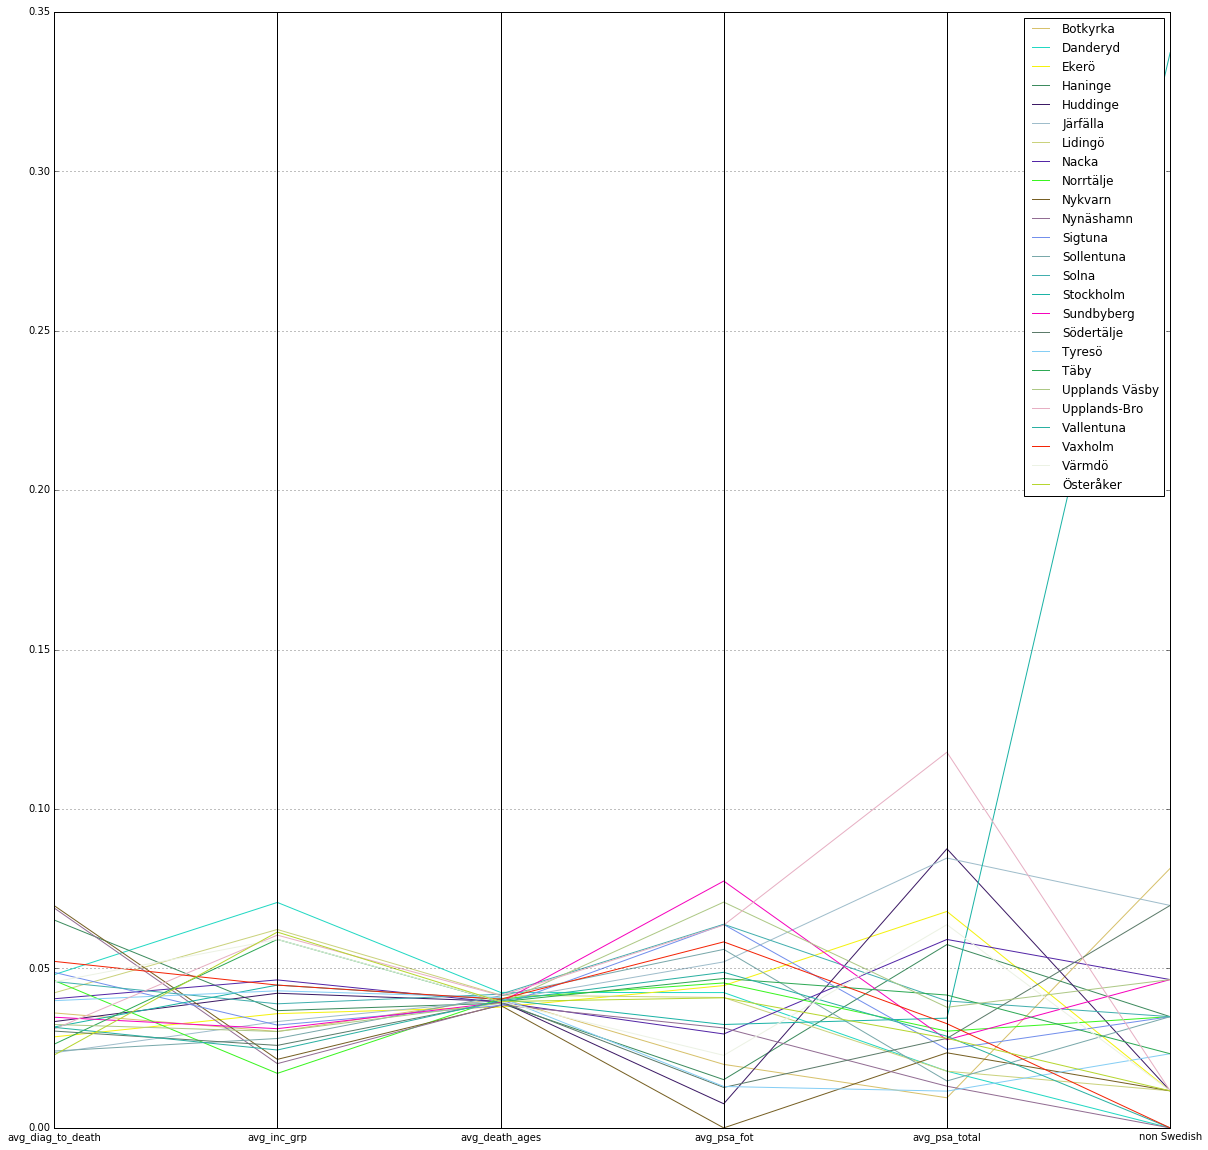

In [13]:
# condition pc_death = 1,
# avg på income
# avg psa,
# avg age of death,
# avg time from diag-date -> death
# antal inte är från Sverige i kommunen
from pandas.tools.plotting import parallel_coordinates
def avg_datetime(series):
    t_min = series.min()
    dt_days = series.apply(lambda date:(date - t_min).days)
    return t_min + pd.to_timedelta(int(dt_days.mean()),unit="D")

pc_dead_pers = PERSON[PERSON.pc_death == 1]
death_ages = pc_dead_pers.death_date - pc_dead_pers.birth_date
death_ages.name = "death_ages"
diag_and_death_date = pc_dead_pers.join(DIAGNOSES)
diag_to_death = diag_and_death_date.death_date - diag_and_death_date.diagdate
diag_to_death.name = "diag_to_death"
avg_psa = PSA.groupby("lopnr_new")[["psa_total","psa_fot"]].mean()

team_death = pc_dead_pers[["inc_grp","birth_place"]].join(diag_to_death).join(avg_psa).join(pers_munip).join(death_ages)
team_death_avg = team_death.groupby("municipality").aggregate({
        "inc_grp":np.mean,
        "birth_place": lambda places: np.count_nonzero(~places.isin(["Sweden"])),
        "diag_to_death": lambda dates: dates.mean(),
        "death_ages":lambda dates: dates.mean(),
        "psa_total":np.mean,
        "psa_fot":np.mean,
    }).rename(columns={
        "birth_place":"non Swedish",
        "inc_grp":"avg_inc_grp",
        "death_ages":"avg_death_ages",
        "diag_to_death":"avg_diag_to_death",
        "psa_total":"avg_psa_total",
        "psa_fot": "avg_psa_fot"
    })

#parallel_coordinates(team_death_avg,"")
#team_death_avg.to_csv(DATASET_BASE + "team_death.csv")
def row_2_numeric(row):
    row.avg_death_ages = row.avg_death_ages.days / 365
    row.avg_diag_to_death = row.avg_diag_to_death.days / 365
    return row

def col_2_norm(col):
    return col / col.sum()

team_death_avg
team_death_avg_num = team_death_avg.apply(row_2_numeric,axis = 1).apply(col_2_norm,axis = 0)
fig = plt.figure(figsize=(20,20))
parallel_coordinates(team_death_avg_num.reset_index(),"municipality")
plt.show()

In [14]:
# condition pc_death = 1,
# avg på income
# avg psa,
# avg age of death,
# avg time from diag-date -> death
# antal inte är från Sverige i kommunen


# team_death = PERSON[["birth_place","birth_date","inc_grp"]].join(
# DIAGNOSES[["diagnosis_cause","diagdate"]]).join(pers_munip).join(latest_psa)

grp = team_death.groupby("municipality")
team_death = team_death.set_index(
    ["municipality"]).sort_index()



grp.aggregate({
        "inc_grp":np.mean,
        "psa_total":np.mean,
        "birth_date": avg_datetime,
        #"diagdate":
    })

team_death

#avg_datetime(team_death["birth_date"])
#gusse.to_csv(DATASET_BASE + "gusse.csv")

#hogler = gusse.join(PERSON[["death_date","pc_death"]])
#hogler = hogler[hogler["pc_death"] == 1].drop("pc_death",axis=1).join(latest_psa)
#hogler.to_csv(DATASET_BASE + "hogler.csv")
#hogler

KeyError: 'birth_date'

In [ ]:
BIOPPSY.reset_index().set_index(["lopnr_new"]).sort_index()

In [ ]:
# Data about where people went missing when they should have had more treatment.
# This requires the defenition of criteria of what requiring further treatment means.
# This will be done in java script
# Here I extract the data that javascript should use
# index: ["munip","lopnr_new"], columns: ["event","date","psa_id","bio_id"]



#pers = PERSON.loc[:,~PERSON.columns.isin(["birth_place"])].join(pers_munip).join(DIAGNOSE)
bio = BIOPPSY[["bioreferral_date","lopnr_new"]].reset_index().rename(columns={
        "bioreferral_date": "date",
    })
bio["event"] = "biopsy"

psa = PSA[["psadate","lopnr_new"]].reset_index().rename(columns={
        "psadate": "date",
    })
psa["event"] = "psa"
diag = DIAGNOSES[["diagdate"]].reset_index().rename(columns={
        "diagdate" : "date",
    })
diag["event"]="diag"
pers_events = pd.concat([bio,psa,diag],axis=0).set_index("lopnr_new").join(
    pers_munip).reset_index()

munip_pers = {}

for i, ((munip,lopnr), group) in enumerate(pers_events.groupby(["municipality","lopnr_new"])):

    if munip not in munip_pers:
        munip_pers[str(munip)] = {}

    if lopnr not in munip_pers[str(munip)]:
        munip_pers[str(munip)][str(lopnr)] = []
    
    str_dates = group.date.apply(lambda date: str(date.date()))
    
    def get_parent_table_keys(row):
        if row.event == "biopsy":
            return row.referral_id_new
        if row.event == "psa":
            return row.psa_sample_id_new
        if row.event == "diag":
            return lopnr
        
        raise Exception("unkown event type")
    
    parent_table_keys = group.apply(get_parent_table_keys,axis=1)
    parent_table_keys.name = "parent_key"
    #str_group = pd.concat([group["event"],str_dates,group[["psa_sample_id_new","referral_id_new"]]],axis=1)
    str_group = pd.concat([group["event"],str_dates,parent_table_keys],axis=1)
    munip_pers[str(munip)][str(lopnr)] += str_group.to_dict(orient = "records")
    
    for j in range(len(munip_pers[str(munip)][str(lopnr)])):
        event = munip_pers[str(munip)][str(lopnr)][j]
        if event["event"] == "psa":
            event["psa_tot"] = PSA.psa_total[event["parent_key"]]
            event["psa_fot"] = PSA.psa_fot[event["parent_key"]]
        elif event["event"] == "biopsy":
            event["cancer_in_bio"] = bool(BIOPPSY.cancer_in_biopsy[event["parent_key"]])
            
        elif event["event"] == "diag":
            event["treatment"] = DIAGNOSES.b_behtyp[event["parent_key"]]
            event["diagnosis_cause"] = DIAGNOSES.diagnosis_cause[event["parent_key"]]
            if not pd.isnull(DIAGNOSES.kem_date[event["parent_key"]]):
                munip_pers[str(munip)][str(lopnr)].append({
                        "event":"first_kem",
                        "date":str(DIAGNOSES.kem_date[event["parent_key"]].date()),
                    })
            
            if not pd.isnull(DIAGNOSES.rad_date[event["parent_key"]]):
                munip_pers[str(munip)][str(lopnr)].append({
                        "event":"first_rad",
                        "date":str(DIAGNOSES.rad_date[event["parent_key"]].date()),
                    })
            if not pd.isnull(DIAGNOSES.surg_date[event["parent_key"]]):
                munip_pers[str(munip)][str(lopnr)].append({
                        "event":"surgery",
                        "date":str(DIAGNOSES.surg_date[event["parent_key"]].date()),
                    })
        else:
            raise Exception("unkown event type")
        
        for key,item in event.items():
            if pd.isnull(item):
                event[key]="NaN"
        
    munip_pers[str(munip)][str(lopnr)].append({
            "event":"birth",
            "date":str(PERSON.birth_date[lopnr].date()),
            "location":PERSON.birth_place[lopnr],
        })
    if PERSON.death[lopnr]:
        munip_pers[str(munip)][str(lopnr)].append({
                "event":"death",
                "date":str(PERSON.death_date[lopnr].date()),
                "pc_death":bool(PERSON.pc_death[lopnr]),
            })
    munip_pers[str(munip)][str(lopnr)].sort(key=lambda event: event["date"])
from pprint import pprint
import json

with open(DATASET_BASE + "person_histories.json",'w') as file:
    json.dump(munip_pers,file,sort_keys=True,indent=4,allow_nan=False)
#str_group.to_dict(orient = "records")

#pers_events_grp = pd.concat([bio,psa,diag],axis=0).set_index("lopnr_new").join(
#    pers_munip).reset_index().set_index(["municipality","lopnr_new"])
#pers_events_grp

In [ ]:
te = []
a = BIOPPSY.iloc[1,:]
b = BIOPPSY.iloc[2,:]
te.append(a.as_matrix().tolist())
te.append(b.as_matrix().tolist())
te